<a href="https://colab.research.google.com/github/AnnikaStephens/Portfolio/blob/main/Feature_selection_based_on_loan_default_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Loan Default Probability 

The goal of this case study is to build a machine learning model to predict the probability that a loan will default.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
        * [3.2.1.  Features elimination by significant missing values ](#2.2.1)
        * [3.2.2.  Features elimination based on the intutiveness](#2.2.2)
        * [3.2.3.  Features elimination based on the correlation](#2.2.3)   
* [4. Feature Engineering and Exploratory Analysis](#3)
    * [4.1 Feature Analysis and Exploration](#3.1)
        * [4.1.1. Analysing the categorical features](#3.1.1)
        * [4.1.2  Analysing the continuous features ](#3.1.2) 
    * [4.2.Encoding Categorical Data](#3.2)
    * [4.3.Sampling Data](#3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Problem Definition

The problem is defined in the classification framework, where the predicted variable
is “placement ”. A charge-off is a debt that a creditor has given up trying to collect on
after you’ve missed payments for several months. The predicted variable takes value 1
in case of charge-off and 0 otherwise.

This case study aims to analyze data for loans through 2007-2017Q3 from Lending Club available on Kaggle. Dataset contains over 887 thousand observations and 150 variables among which one is describing the loan status. 

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
## 2.2. Loading the Data

We load the data in this step.

#### <font color='red'>Note : Due to limit in the github for the data size, a sample of the data has been loaded in the jupyter notebook repository of this book. However, all the subsequent results in this jupyter notebook is with actual data (~1GB) under https://www.kaggle.com/mlfinancebook/lending-club-loans-data. You should load the full data in case you want to reproduce the results. </font> 

In [ ]:
#load dataset
import io
import pandas as pd
from google.colab import files

uploaded = files.upload()

In [ ]:
placement = pd.read_excel(io.BytesIO(uploaded.get('MBAselection.xlsx')))

In [ ]:
dataset = placement

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable


In [ ]:
# We're going to try to predict the placement_status variable. What are the value counts for this variable
dataset['Placement'].value_counts(dropna=False)

Placed        312
Not Placed     79
Name: Placement, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [ ]:
dataset = dataset.loc[dataset['Placement'].isin(['Placed', 'Not Placed'])]

dataset['Placement'].value_counts(dropna=False)

dataset['Placement'].value_counts(normalize=True, dropna=False)

Placed        0.797954
Not Placed    0.202046
Name: Placement, dtype: float64

About 80% of the remaining loans have been fully paid and 20% have charged off, so we have a somewhat unbalanced classification problem.

In [ ]:
dataset['Placed'] = (dataset['Placement'] == 'Placed').apply(np.uint8)
dataset.drop('Placement', axis=1, inplace=True)

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

The full dataset has 150 features for each
loan. We’ll eliminate
features in following steps using three different approaches:
* Eliminate feature that have more than 30% missing values.
* Eliminate features that are unintuitive based on subjective judgement.
* Eliminate features with low correlation with the predicted variable

<a id='2.2.2'></a>
### 3.2.2.  Features elimination - intutiveness

In order to filter the features further we check the description in the data dictionary and keep the features that are
intuitive on the basis of subjective judgement. 

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [ ]:
print(sorted(dataset.columns))

['Board_CBSE', 'Board_HSC', 'Board_ICSE', 'Board_SSC', 'Course_Degree', 'Degree_Engg', 'Entrance_Test', 'Experience_Yrs', 'Gender', 'Gender-B', 'Marks_BOCA', 'Marks_Communication', 'Marks_Projectwork', 'Percent_Degree', 'Percent_HSC', 'Percent_MBA', 'Percent_SSC', 'Percentile_ET', 'Placed', 'Placement_B', 'S-TEST', 'S-TEST*SCORE', 'Salary', 'SlNo', 'Specialization_MBA', 'Stream_HSC']


The list that is kept is as follows: 

In [ ]:
keep_list = ['Board_CBSE', 'Board_HSC', 'Board_ICSE', 'Board_SSC', 'Course_Degree', 'Degree_Engg', 'Entrance_Test', 'Experience_Yrs', 'Gender', 'Gender-B', 'Marks_BOCA', 'Marks_Communication', 'Marks_Projectwork', 'Percent_Degree', 'Percent_HSC', 'Percent_MBA', 'Percent_SSC', 'Percentile_ET', 'Placement', 'Placement_B', 'S-TEST', 'S-TEST*SCORE', 'Specialization_MBA', 'Stream_HSC']

len(keep_list)

24

In [ ]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

(391, 23)

<a id='2.2.3'></a>
### 3.2.3.  Features elimination based on the correlation

In [ ]:
correlation = dataset.corr()
correlation_Placed = abs(correlation['Placed'])

KeyError: ignored

In [ ]:
correlation_NotPlaced.sort_values(ascending=False)

Placement_B            1.000000
Not_Placed             1.000000
Percent_SSC            0.168500
Percentile_ET          0.130938
S-TEST*SCORE           0.130938
Marks_Projectwork      0.105943
Percent_MBA            0.079643
Marks_BOCA             0.069151
Experience_Yrs         0.064843
Gender-B               0.059032
Board_CBSE             0.053834
Percent_HSC            0.052237
Percent_Degree         0.052120
S-TEST                 0.041632
Board_ICSE             0.023104
Marks_Communication    0.010575
Degree_Engg            0.010352
Name: Not_Placed, dtype: float64

In [ ]:
drop_list_corr = sorted(list(correlation_NotPlaced[correlation_NotPlaced < 0.03].index))
print(drop_list_corr)

['Board_ICSE', 'Degree_Engg', 'Marks_Communication']


In [ ]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(391, 21)

<a id='3'></a>
# 4. Feature Engineering and Exploratory Analysis

In [ ]:
#Descriptive Statistics
dataset.describe()

,Gender-B,Percent_SSC,Board_CBSE,Percent_HSC,Percent_Degree,Experience_Yrs,S-TEST,Percentile_ET,Percent_MBA,S-TEST*SCORE,Marks_Projectwork,Marks_BOCA,Placement_B,Not_Placed
count,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000
mean,0.324808,64.652353,0.289003,63.795294,62.983606,0.478261,0.828645,54.934962,61.667698,54.934962,68.363171,64.378517,0.797954,0.202046
std,0.468903,10.960426,0.453880,11.417726,8.916152,0.667112,0.377302,31.168264,5.854399,31.168264,7.145095,9.582834,0.402041,0.402041
min,0.000000,37.000000,0.000000,40.000000,35.000000,0.000000,0.000000,0.000000,50.830000,0.000000,50.000000,50.000000,0.000000,0.000000
25%,0.000000,56.000000,0.000000,54.000000,57.525000,0.000000,1.000000,41.190000,57.195000,41.190000,64.000000,57.000000,1.000000,0.000000
50%,0.000000,64.500000,0.000000,63.000000,63.000000,0.000000,1.000000,62.000000,61.010000,62.000000,69.000000,63.000000,1.000000,0.000000
75%,1.000000,74.000000,1.000000,72.000000,69.000000,1.000000,1.000000,78.000000,66.020000,78.000000,74.000000,72.500000,1.000000,0.000000
max,1.000000,87.200000,1.000000,94.700000,89.000000,3.000000,1.000000,98.690000,77.890000,98.690000,87.000000,96.000000,1.000000,1.000000


<a id='3.1'></a>
## 4.1 Feature Analysis and Exploration

<a id='3.1.1'></a>
### 4.1.1. Analysing the categorical features 

#### Feature- Employement Length

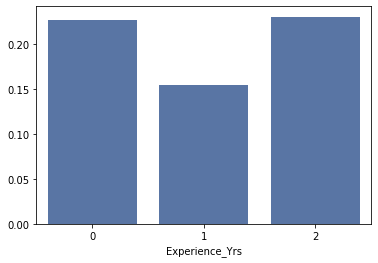

In [ ]:
NotPlaced_rates = dataset.groupby('Experience_Yrs')['Not_Placed'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=NotPlaced_rates.index, y=NotPlaced_rates.values, color='#5975A4', saturation=1)

Placement seems to vary a bit depending on years of experience; 1 year of experience seems to place the most.

#### Feature : Test scores

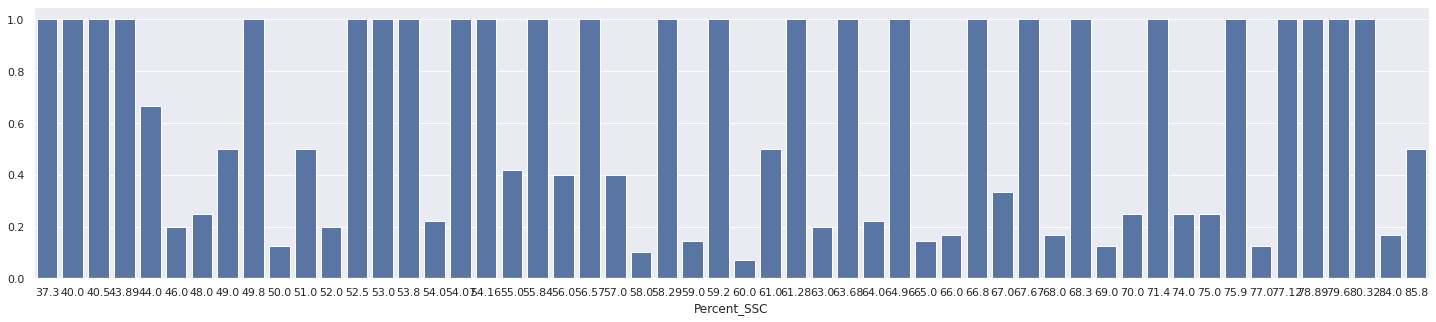

In [ ]:
NotPlaced_rates = dataset.groupby('Percent_SSC')['Not_Placed'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(25,5)})
sns.barplot(x=NotPlaced_rates.index, y=NotPlaced_rates.values, color='#5975A4', saturation=1)


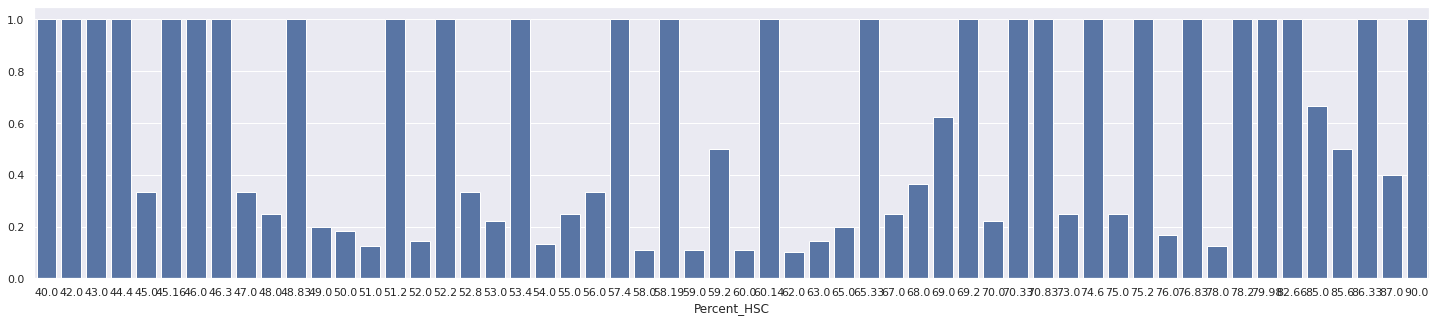

In [ ]:
NotPlaced_rates = dataset.groupby('Percent_HSC')['Not_Placed'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(25,5)})
sns.barplot(x=NotPlaced_rates.index, y=NotPlaced_rates.values, color='#5975A4', saturation=1)


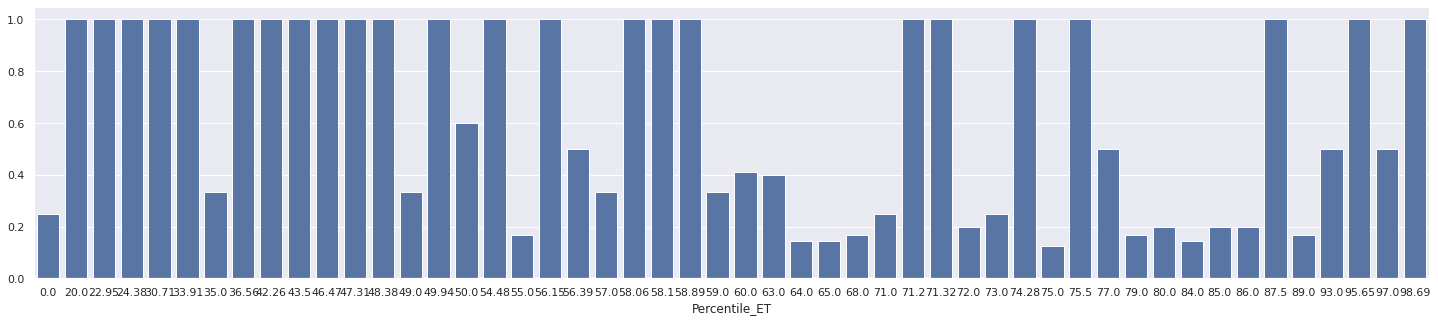

In [ ]:
NotPlaced_rates = dataset.groupby('Percentile_ET')['Not_Placed'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(25,5)})
sns.barplot(x=NotPlaced_rates.index, y=NotPlaced_rates.values, color='#5975A4', saturation=1)

There is NOT a clear trend that shows the SSCL scores against students not being placed.

<a id='3.1.2'></a>
### 4.1.2. Analysing the continuous features 

#### Feature : Annual Income

In [ ]:
dataset[['annual_inc']].describe()

Annual income ranges from 0  to  9,550,000, with a median of $65,000. 
Because of the large range of incomes, we should take a log transform of the annual income variable.

In [ ]:
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)

#### FICO Scores

In [ ]:
dataset[['fico_range_low','fico_range_high']].corr()

Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores

In [ ]:
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']

dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [ ]:
dataset['charged_off'].value_counts()

<a id='3.2'></a>
## 4.2. Encoding Categorical Data

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

In [ ]:
categorical_cols

In [ ]:
le = LabelEncoder()
# apply le on categorical feature columns
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))
dataset[categorical_cols].head(10)

In [ ]:
dataset.head(5)

In [ ]:
dataset.shape

<a id='3.4'></a>
## 4.3. Sampling Data

In [ ]:
loanstatus_0 = dataset[dataset["charged_off"]==0]
loanstatus_1 = dataset[dataset["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()

In [ ]:
#Filling the NAs with the mean of the column.
dataset.fillna(dataset.mean(),inplace = True)

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [ ]:
# split out validation dataset for the end
Y= dataset["charged_off"]
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [ ]:
# dataset_temp2=dataset_temp.dropna(axis=0)
# Y_total= dataset_temp2["charged_off"]
# X_total = dataset_temp2.loc[:, dataset.columns != 'charged_off']
# X_dummy, X_validation, Y_dummy, Y_validation = train_test_split(X_total, Y_total, test_size=validation_size)

In [ ]:
dataset['charged_off'].value_counts()

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [ ]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

### Classification Models

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

### K-folds cross validation

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

### Algorithm comparison

In [ ]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Given that the GBM is the best model, Grid Search is performed on GBM in this step.

In [ ]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

<a id='6'></a>
# 7. Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [ ]:
# prepare model
model = GradientBoostingClassifier(max_depth= 5, n_estimators= 180)
model.fit(X_train, Y_train)

In [ ]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.
Let us look into the Feature Importance of the GBM model

In [ ]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

__Conclusion__:

We showed that data preparation is one of the most important steps. We addressed
that by performing feature elimination by using different techniques such as subjec‐
tive judgement, correlation, visualization and the data quality of the feature.
We illustrated that there can be different ways of handling and analyzing the categorical data and converting categorical data into model usable format.

Finally, we analyzed the feature importance and found that results of the case study
are quite intuitive.

